In [25]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
ls "/content/drive/My Drive/Colab Notebooks/BCI_Final/"

1DCNN_2ch_2class_push_vad.ipynb  1DCNNmodel.pt
1DCNN_2ch_4class_push_vad.ipynb  gameemo_train_test.pt
1DCNNmodel_4class_2ch.pt         Push-vad.ipynb


In [27]:
!pip install requests
import requests
import time

In [28]:
import os, glob, random, numpy as np, pandas as pd, torch
from scipy.signal import butter, lfilter, iirnotch
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================================================================================================
datapath = "/content/drive/My Drive/Colab Notebooks/BCI_Final/gameemo_train_test.pt"
modelpath = "/content/drive/My Drive/Colab Notebooks/BCI_Final/1DCNNmodel_4class_2ch.pt"
API_URL = "https://tw-cheer-up-system.onrender.com/predict"
# =====================================================================================================
# 定義推送函式
def send_vad(v, a, d):
    payload = {"vad": [v, a, d]}
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(API_URL, json=payload, headers=headers)
        if response.status_code == 200:
            print(f"成功送出 VAD: {payload} ➜ Response: {response.json()}")
        else:
            print(f"送出失敗，狀態碼: {response.status_code}, 回應內容: {response.text}")
    except Exception as e:
        print(f"發生錯誤: {e}")

# =====================================================================================================
# 定義 normalize 函式
def normalize_vad(v, a):
  V_ratio = v[0][1] / (v[0][0] + v[0][1])
  V_light = 1.00 + 0.10 * float(V_ratio)  # 轉為 double

  A_ratio = a[0][1] / (a[0][0] + a[0][1])
  A_light = float(A_ratio)  # 已經是 0~1 的 double

  D_light = 0.0

  return V_light, A_light, D_light
# =====================================================================================================

<ipython-input-29-2dfda9853e63>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_te_b = torch.where(torch.tensor(y_te) < 2, 0, 1)  # 將原始label轉換為二類：label < 2 為 0，其餘為 1
<ipython-input-29-2dfda9853e63>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_te).float().to(device),


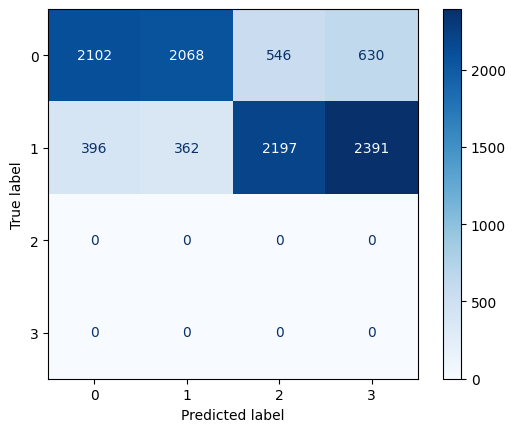

test accuracy: 0.23045267489711935


In [29]:
data = torch.load(datapath)                # 載入資料
y_te = data['test'][1]                  # 取得test set的標label
X_te = data['test'][0]                  # 取得test set的feature
device = torch.device('cpu')
val_size = int(X_te.shape[0])               # test set的樣本數
y_te_b = torch.where(torch.tensor(y_te) < 2, 0, 1)  # 將原始label轉換為二類：label < 2 為 0，其餘為 1
te_set = TensorDataset(
    torch.tensor(X_te).float().to(device),
    y_te_b.long().to(device))
BATCH_SIZE = 1                     # 設定批次大小
te_loader = DataLoader(te_set, batch_size=BATCH_SIZE) # 建立test set DataLoader

# =====================================================================================================
class CNN1D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (256 // 4), 256)##########need to chang from 128 to 256 here!!!!!!!!!!!!!!!!!!!!
        self.fc2 = nn.Linear(256, num_classes)##########need to chang from 128 to 256 here!!!!!!!!!!!!!!!!!!!!

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# =====================================================================================================
# 載入預訓練模型（含結構與權重）
load_model = torch.load(modelpath,weights_only=False,map_location="cpu")

# 初始化預測與標籤記錄器
all_preds = []
all_labels = []
correct = 0
total = 0
load_model.eval()

# 設為評估模式
with torch.no_grad(): # 測試時不需計算梯度
    for x_batch, y_batch in te_loader:
        outputs = load_model(x_batch)
        preds = outputs.argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 計算整體準確率
val_acc = correct / total

# 計算混淆矩陣
cm = confusion_matrix(all_labels, all_preds)

# 顯示混淆矩陣 & 測試準確率
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues');plt.show()
print("test accuracy:", val_acc)

In [ ]:
#####專注度( 1是專注 0是不專注 )、正向度( 1是正向 0是不正向 )
# 初始化變數，用於繪圖
total = 0  # 總樣本數
tcount_V = 0  # V值預測正確數
tcount_A = 0  # A值預測正確數
tcount = 0  # 預測正確的樣本數
yplot = []  # 真實標籤
xplot_V = []  # V通道 softmax 類別1機率
xplot_A = []  # A通道 softmax 類別1機率

# =====================================================================================================
# 定義 softmax 函數，將模型輸出轉換為機率分佈
softmaxfunction = nn.Softmax(dim=1)

with torch.no_grad():
    for x_batch, y_batch in te_loader:
        outputs = load_model(x_batch)
        # print("Shape of output:",outputs.shape)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()  # 計算預測正確的數量

        # = push vad =============================================================
        input_V = torch.tensor([[outputs[0][2], outputs[0][3]]], dtype=torch.float32)
        input_A = torch.tensor([[outputs[0][1], outputs[0][3]]], dtype=torch.float32)

        softmaxoutput_V = softmaxfunction(input_V)
        softmaxoutput_A = softmaxfunction(input_A)

        # print("softmaxoutput_V:",softmaxoutput_V)
        # print("softmaxoutput_A:",softmaxoutput_A)

        v, a, d = normalize_vad(softmaxoutput_V, softmaxoutput_A)
        send_vad(v, a, d)

        # = 統計個別分類準確度 =============================================================
        pred_V = float(softmaxoutput_V[0][1])
        pred_A = float(softmaxoutput_A[0][1])

        if int(y_batch[0]) in [2, 3]:
            label = 1
        else:
            label = 0
        # 儲存結果以便畫圖
        yplot.append(label)
        xplot_V.append(pred_V)
        xplot_A.append(pred_A)
        total += 1

        # print("Label:",labelsum," softmax Predict:",float(softmaxoutputsum))
        if (pred_V >= 0.5 and label == 1) or (pred_V < 0.5 and label == 0):
            tcount_V += 1

        # 檢查 A channel 是否預測正確
        if (pred_A >= 0.5 and label == 1) or (pred_A < 0.5 and label == 0):
            tcount_A += 1

# =====================================================================================================
# V channel 可視化
fig, ax1 = plt.subplots(figsize=(20, 6))
lns1 = ax1.plot(range(total), xplot_V, label='Predict (V)', color='blue')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Softmax V Probability')

ax2 = ax1.twinx()
lns2 = ax2.plot(range(total), yplot, color='orange', label='True Label')
ax2.set_ylabel('True Label')

plt.title('V Prediction vs Label')
handles = lns1 + lns2
labels = [l.get_label() for l in handles]
ax1.legend(handles, labels, loc='upper right')
plt.show()

# ==================================================================================
# A channel 可視化
fig, ax1 = plt.subplots(figsize=(20, 6))
lns1 = ax1.plot(range(total), xplot_A, label='Predict (A)', color='green')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Softmax A Probability')

ax2 = ax1.twinx()
lns2 = ax2.plot(range(total), yplot, color='orange', label='True Label')
ax2.set_ylabel('True Label')

plt.title('A Prediction vs Label')
handles = lns1 + lns2
labels = [l.get_label() for l in handles]
ax1.legend(handles, labels, loc='upper right')
plt.show()

# ==================================================================================
# 準確率顯示
print(f"Accuracy (V channel): {tcount_V / total:.4f}")
print(f"Accuracy (A channel): {tcount_A / total:.4f}")

print(f"Overall accuracy (argmax): {correct / total:.4f}")

成功送出 VAD: {'vad': [1.0999670445919036, 0.13837945461273193, 0.0]} ➜ Response: {'brightness': 0.569189727306366, 'color_hue': 377.9940680265427, 'pulse_speed': 0.5}
成功送出 VAD: {'vad': [1.0000000020729707, 5.8162557252217084e-05, 0.0]} ➜ Response: {'brightness': 0.5000290812786261, 'color_hue': 360.0000003731347, 'pulse_speed': 0.5}
成功送出 VAD: {'vad': [1.1, 0.9999959468841553, 0.0]} ➜ Response: {'brightness': 0.9999979734420776, 'color_hue': 378.0, 'pulse_speed': 0.5}
成功送出 VAD: {'vad': [1.0000000002575309, 7.928021545922093e-07, 0.0]} ➜ Response: {'brightness': 0.5000003964010773, 'color_hue': 360.0000000463556, 'pulse_speed': 0.5}
成功送出 VAD: {'vad': [1.0956183791160583, 1.0849865006434811e-08, 0.0]} ➜ Response: {'brightness': 0.5000000054249325, 'color_hue': 377.21130824089056, 'pulse_speed': 0.5}
成功送出 VAD: {'vad': [1.0978047907352448, 0.0028410733211785555, 0.0]} ➜ Response: {'brightness': 0.5014205366605893, 'color_hue': 377.60486233234406, 'pulse_speed': 0.5}
成功送出 VAD: {'vad': [1.006088